In [61]:
# Reproject and resample the EASE v1 grid into the EASE v2 grid

import xarray
import rioxarray

v1_path = r"../data\raw\AMSRU_Mland_2017001A.tif"
v2_path = r"../data\raw\ka_36ghz\Ascending\GW1AM2_20170101_01D_EQMA_L3SGT36LA2220220_corrected.h5"


In [112]:
# Load the files:

v1_data = rioxarray.open_rasterio(v1_path, masked=True)
v2_data = xarray.open_dataset(v2_path)

# Apply the v2 data scaling factors:

for dvar in v2_data.data_vars:
    v2_data[dvar] *= v2_data[dvar].attrs["SCALE FACTOR"]

v1_data.sizes, v2_data.sizes


(Frozen({'band': 7, 'y': 586, 'x': 1383}), Frozen({'lon': 1388, 'lat': 584}))

In [84]:
""" 
In theory, v1 is EPSG:3410 and v2 is EPSG:6933
"""
v1_data.rio.crs, v2_data.rio.crs

(CRS.from_epsg(3410), None)

Frozen({'band': 7, 'y': 584, 'x': 1388})


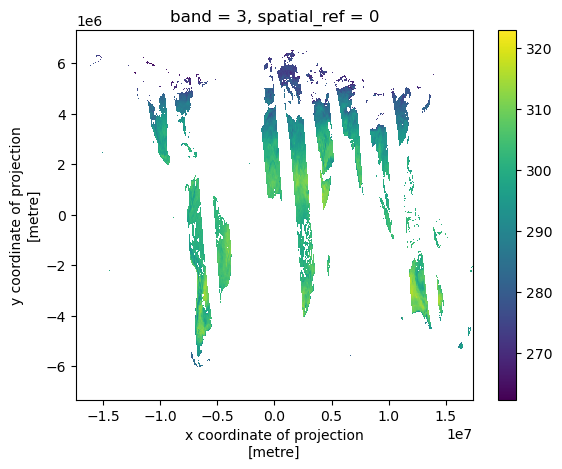

In [111]:
# Reproject and resample v1 data into v2
v1_land = v1_data.where(v1_data>-999) # Remove missing data
rv1_data = v1_land.rio.reproject("EPSG:6933", shape = v2_data["Brightness Temperature (H)"].shape)
rv1_data.sel(band=3).plot()
print(rv1_data.sizes)

In [86]:
# In order to compare, we need to get the projected x,y dimensions in the v2 data
from pyproj import Proj, transform
import numpy as np
# Define the EPSG codes for the source (WGS84) and target (EPSG:6933) coordinate systems
source_proj = Proj(init='epsg:4326')  # WGS84
target_proj = Proj(init='epsg:6933')  # EPSG:6933

# Your latitude and longitude coordinates
lats = v2_data.lat.values
lons = v2_data.lon.values

latarr,lonarr = np.meshgrid(lats,lons)

# Convert latitude and longitude to projected coordinates
x_coords, y_coords = transform(source_proj, target_proj, lonarr, latarr)

c:\Users\andre\Desktop\VS_Code\PMW_LST\.conda\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\andre\Desktop\VS_Code\PMW_LST\.conda\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\andre\AppData\Local\Temp\ipykernel_9192\2656198596.py:15: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading

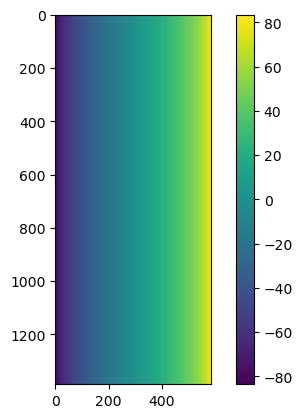

In [87]:
import matplotlib.pyplot as plt
plt.imshow(latarr)
plt.colorbar()

In [88]:
# Add x and y projection coordinates as variables
v2_data["x"] = (("lon",),x_coords[:,0])
v2_data["y"] = (("lat",),y_coords[0,:])


# Now set the new coordinates and csr:
v2_data.rio.write_crs("EPSG:6933")

v2_data = v2_data.assign_coords(
    {
        "x":v2_data.x,
        "y":v2_data.y
    },
)


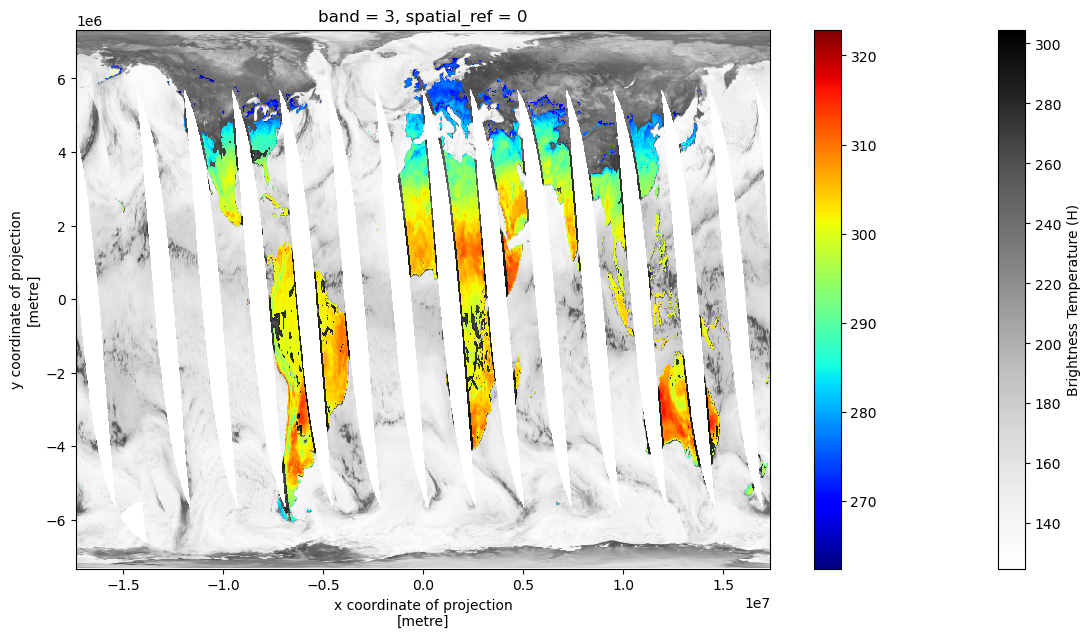

In [93]:
fig, ax = plt.subplots(1,1,figsize=(14,7))
v2_data["Brightness Temperature (H)"].plot(x="x",y="y", ax=ax, cmap="Grays")
rv1_data.sel(band=3).plot(cmap="jet", ax=ax)

(4000000.0, 6000000.0)

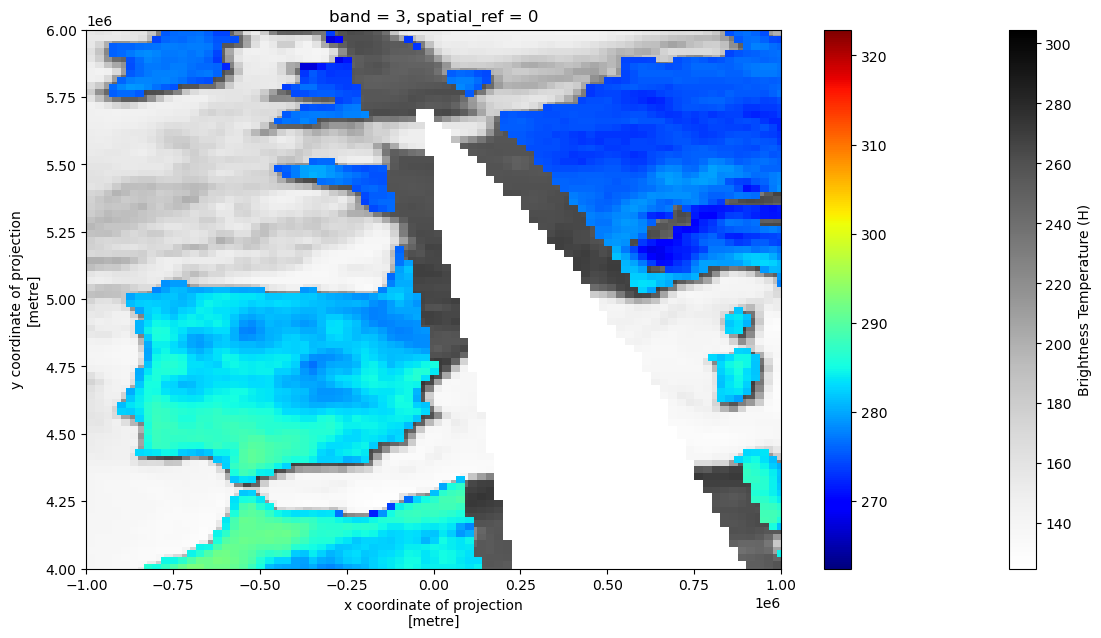

In [99]:
# Zoom into a region to check if the matching is correct:
fig, ax = plt.subplots(1,1,figsize=(14,7))
v2_data["Brightness Temperature (H)"].plot(x="x",y="y", ax=ax, cmap="Grays")
rv1_data.sel(band=3).plot(cmap="jet", ax=ax)

x_lims = (-0.1*10**7, 0.1*10**7)
y_lims = (4*10**6, 6*10**6)

ax.set_xlim(x_lims[0], x_lims[1])
ax.set_ylim(y_lims[0], y_lims[1])

(2000000.0, 6000000.0)

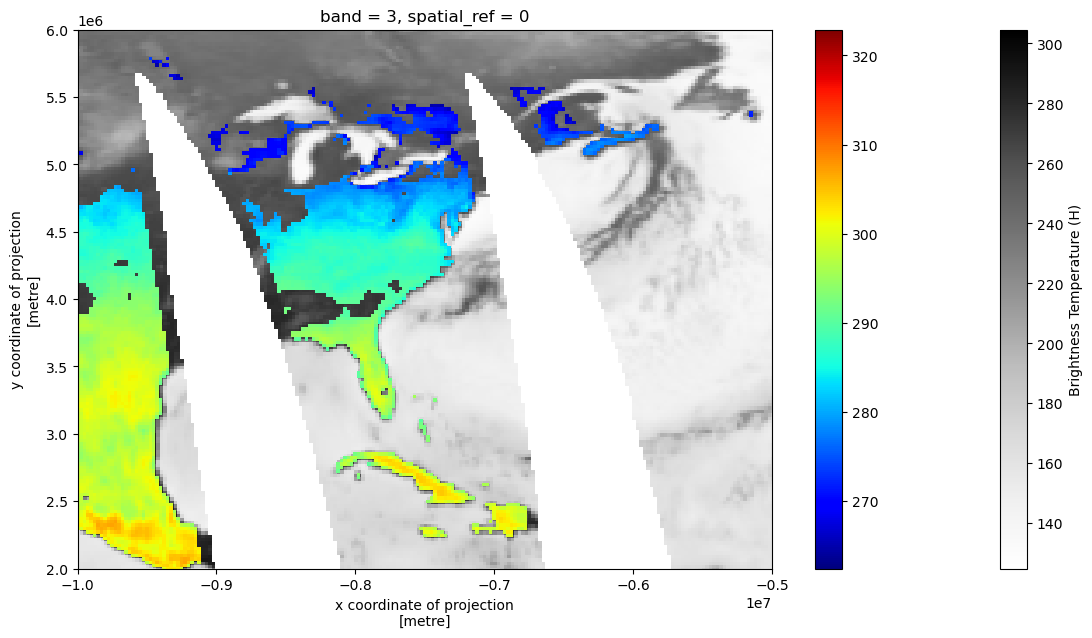

In [102]:
# Zoom into a region to check if the matching is correct:
fig, ax = plt.subplots(1,1,figsize=(14,7))
v2_data["Brightness Temperature (H)"].plot(x="x",y="y", ax=ax, cmap="Grays", label="EASEv2")
rv1_data.sel(band=3).plot(cmap="jet", ax=ax, label="Reprojected EASEv1")

x_lims = (-1*10**7, -0.5*10**7)
y_lims = (2*10**6, 6*10**6)

ax.set_xlim(x_lims[0], x_lims[1])
ax.set_ylim(y_lims[0], y_lims[1])


(0.0, -1000000.0)

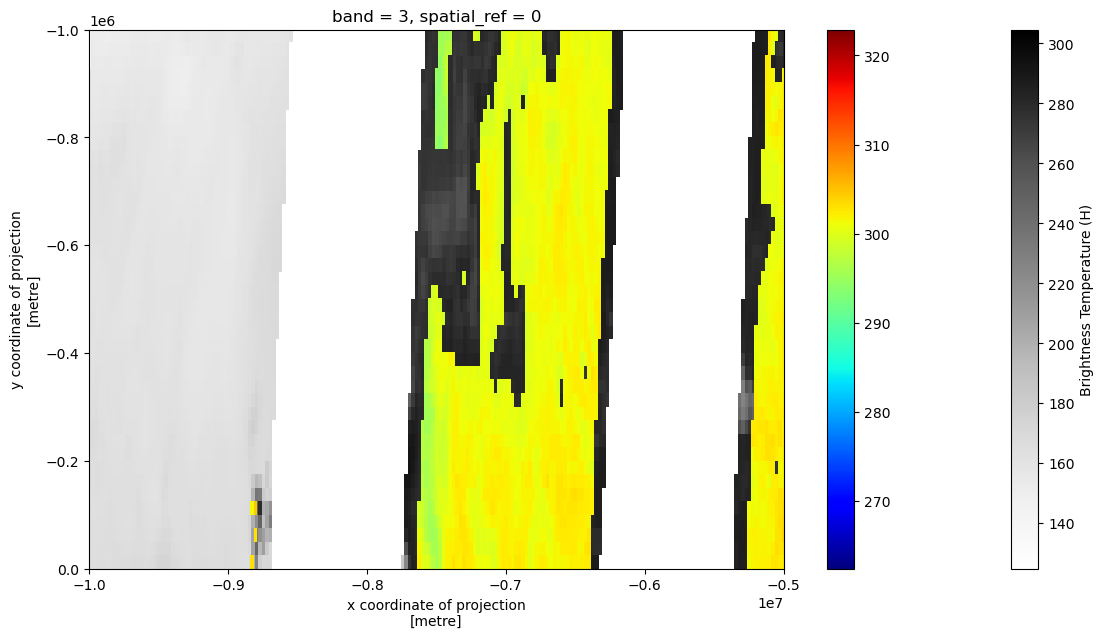

In [110]:
# Zoom into a region to check if the matching is correct:
fig, ax = plt.subplots(1,1,figsize=(14,7))
v2_data["Brightness Temperature (H)"].plot(x="x",y="y", ax=ax, cmap="Grays", label="EASEv2")
rv1_data.sel(band=3).plot(cmap="jet", ax=ax, label="Reprojected EASEv1")

x_lims = (-1*10**7, -0.5*10**7)
y_lims = (0*10**6, -1*10**6)

ax.set_xlim(x_lims[0], x_lims[1])
ax.set_ylim(y_lims[0], y_lims[1])
